In [1]:
from noble_model_add_vgcc import ModifiedNobleModel
from fluorescence_encoder import FluorescenceEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 

In [2]:
T = 20
dt = 0.001

In [10]:
class SingleCellCalciumModel(ModifiedNobleModel):
    def __init__(self):
        super().__init__()
        self.ct0 = 35
        self.hh0 = None
        self.ip0 = 0.01
        self.gamma = 5.4054
        self.delta = 0.2
        self.v_ip3r = 7 # 8 # 5 # 100 # 0.222
        self.d_1 = 0.01 # 0.13
        self.d_2 = 1.049
        self.d_3 = 0.9434
        self.d_4 = 0.13 # 0.13
        self.d_5 = 0.08234
        self.a_2 =  6.4 # 6.4 # 0.04
        self.ip_decay = 0.5
        self.time = np.linspace(0, T, int(T/dt))
    
    # Calcium terms
    def i_ip3r(self, c, c_t, hh, ip):
        mm_inf = ip/(ip + self.d_1)
        nn_inf = c/(c + self.d_5)
        return self.v_ip3r * mm_inf**3 * nn_inf**3 * hh**3 * \
            ((c_t-c)*self.gamma - c)
    
    def i_serca(self, c):
        v_serca =  20 # 18 # 0.9
        k_serca = 0.08 # 0.1
        return v_serca * c**1.75 / (c**1.75 + k_serca**1.75)
    
    def i_leak(self, c, c_t):
        v_leak = (- self.i_ip3r(self.c0, self.ct0, self.hh0, self.ip0) \
                  + self.i_serca(self.c0)) \
                  / ((self.ct0-self.c0)*self.gamma - self.c0)
        
        return v_leak * ((c_t-c)*self.gamma - c)
    
    def i_pmca(self, c):
        k_pmca =  1.5 #2.5 
#         v_pmca = - self.i_cal(self.v0) \
#         / (self.c0**2 / (k_pmca**2 + self.c0**2))
        v_pmca = 15 # 15 # 25
        
        return v_pmca * c**2 / (k_pmca**2 + c**2)
    
    def i_soc(self, c, c_t):
        
        v_soc = 0
        k_soc = 0
        
        return v_soc * k_soc**4 / (k_soc**4 + ((c_t-c)*self.gamma)**4)
    
    def i_out(self, c):
        k_out = (- self.i_cal(self.v0) - self.i_pmca(self.c0) + self.i_soc(self.c0, self.ct0)) \
        / self.c0
        return k_out*c
    
    def hh_inf(self, c, ip):
        q_2 = self.d_2 * (ip + self.d_4)/(ip + self.d_3)
        return q_2 / (q_2 + c)
    
    def tau_hh(self, c, ip):
        q_2 = self.d_2 * (ip + self.d_4)/(ip + self.d_3)
        return 1 / (self.a_2 * (q_2 + c))
    
    # Override
    def stim(self, t):
        if t >= 10 and t < 10.1 or t >= 12 and t < 12.1 or t >= 14 and t < 14.1:
            return 0.5
        else:
            return 0
    
    # Override
    def rhs(self, y, t):
        c, c_t, hh, ip, v, m, h, n = y
    
        dcdt = 1.0 * (self.i_ip3r(c, c_t, hh, ip) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v) \
                + self.i_soc(c, c_t) \
                - self.i_out(c)) * self.delta
        
        dctdt = 1.0 * (- self.i_pmca(c) \
                       - self.i_cal(v) \
                       + self.i_soc(c, c_t) \
                       - self.i_out(c))\
                 * self.delta

        dhhdt =  1.0 * (self.hh_inf(c, ip) - hh) / self.tau_hh(c, ip)

#         dipdt = 0.005 - self.ip_decay * ip 

        dipdt = 0

        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
                  + 2*self.i_cal(v)\
                  - self.stim(t))/self.c_m
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n

        return [dcdt, dctdt, dhhdt, dipdt, dvdt, dmdt, dhdt, dndt]
        
    # Override
    def step(self):
        self.hh0 = self.hh_inf(self.c0, self.ip0)
        
        y0 = [self.c0, self.ct0, self.hh0, self.ip0,
              self.v0, self.m0, self.h0, self.n0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol

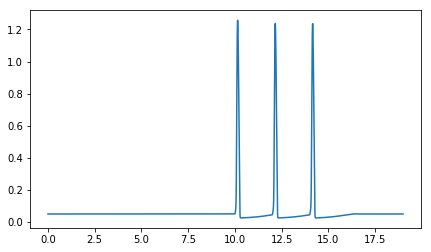

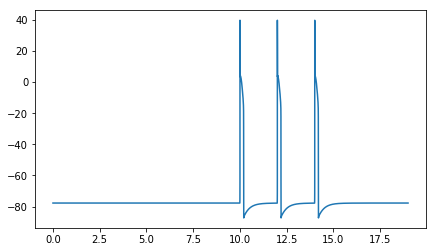

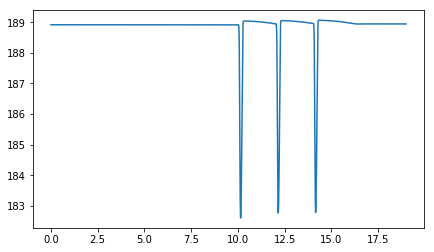

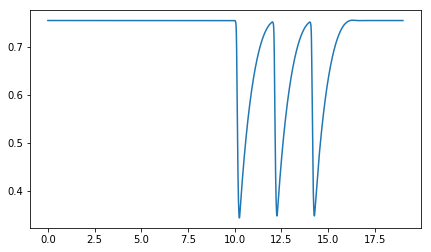

In [11]:
if __name__ == '__main__':
    aa = SingleCellCalciumModel()
    sol = aa.step()
    c = sol[:,0]
    c_t = sol[:,1]
    hh = sol[:,2]
    ip = sol[:,3]
    v = sol[:,4]
    m = sol[:,5]
    h = sol[:,6]
    n = sol[:,7]
    aa.plot(c)
    aa.plot(v)
    aa.plot((c_t - c)*aa.gamma)
    aa.plot(hh)

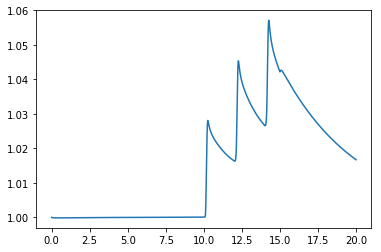

In [12]:
plt.plot(aa.time, FluorescenceEncoder(c).step())
plt.show()

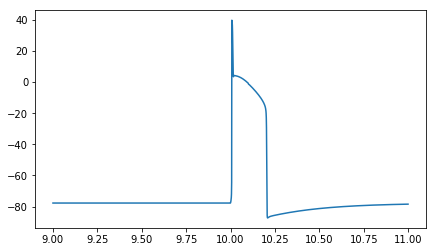

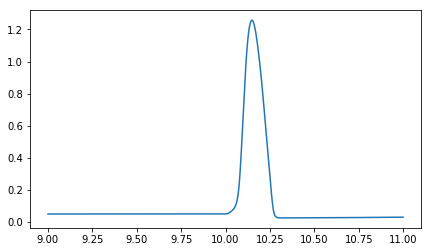

In [13]:
aa.plot(v, 9, 11)
aa.plot(c, 9, 11)

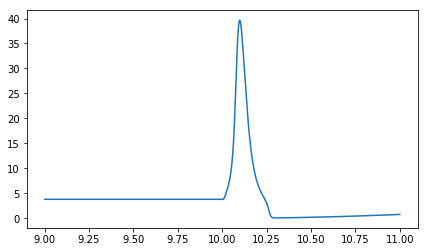

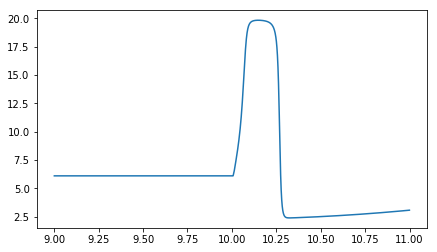

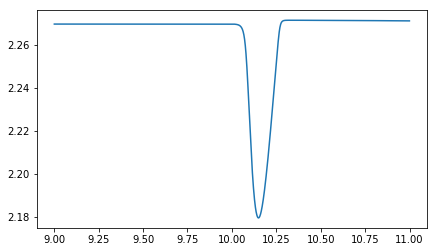

In [14]:
aa.plot(aa.i_ip3r(c, c_t, hh, ip), 9, 11)
aa.plot(aa.i_serca(c), 9, 11)
aa.plot(aa.i_leak(c, c_t), 9, 11)